[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
> Average Accuracy across 10-folds: 91.16% (+/- 1.20%)


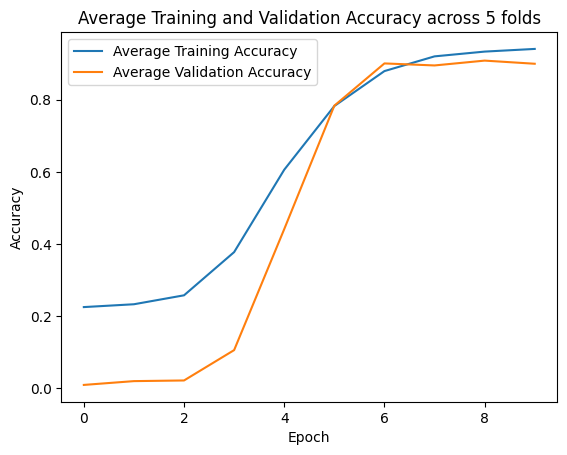

268/268 [==============================] - 6s 23ms/step


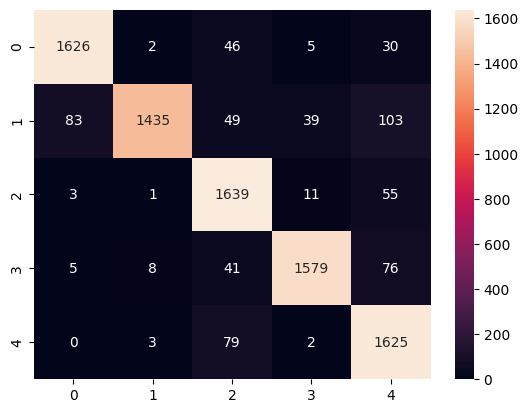

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1709
           1       0.99      0.84      0.91      1709
           2       0.88      0.96      0.92      1709
           3       0.97      0.92      0.94      1709
           4       0.86      0.95      0.90      1709

    accuracy                           0.92      8545
   macro avg       0.93      0.92      0.93      8545
weighted avg       0.93      0.92      0.93      8545



In [ ]:
# Cell 1: Setup and Imports
!pip install nltk
!pip install imbalanced-learn
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from nltk.stem import WordNetLemmatizer
from nltk import download
download('wordnet')
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler

# Cell 2: Mount Google Drive
drive.mount('/content/drive')

# Cell 3: Data Loading and Preprocessing
# Replace 'path_to_your_dataset' with the actual path to your CSV file in Google Drive
path = '/content/drive/MyDrive/Sarcasm_multiclassification.csv'
df = pd.read_csv(path, encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['comment_Text'] = df['comment_Text'].apply(clean_text)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment_Text'])
X = tokenizer.texts_to_sequences(df['comment_Text'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)
y = pd.get_dummies(df['Sarcasm_Type']).values

# Cell 4: Oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Cell 5: Model Definition
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Cell 6: K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)

    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Cell 7: Results Visualization
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 5 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Cell 8: Performance Metrics
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

print(classification_report(y_true_classes, y_pred_classes))

# End of Notebook


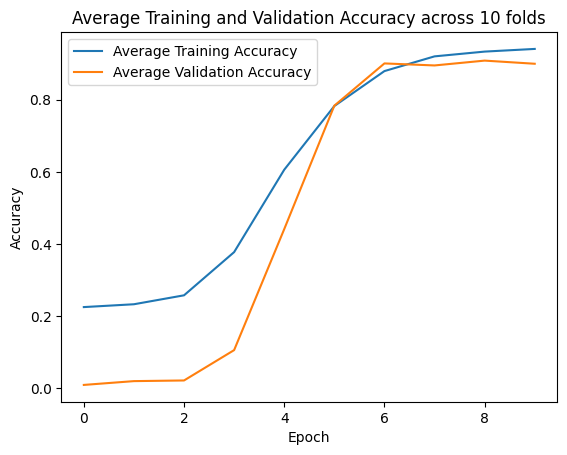

268/268 [==============================] - 8s 30ms/step


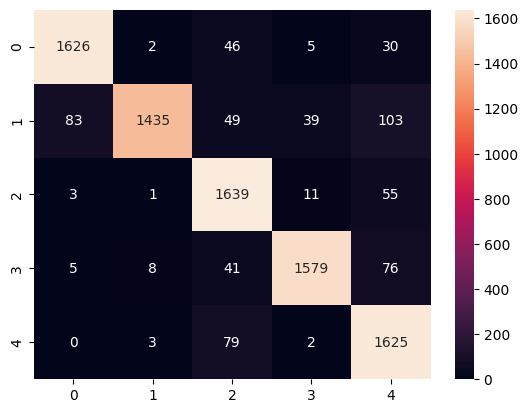

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1709
           1       0.99      0.84      0.91      1709
           2       0.88      0.96      0.92      1709
           3       0.97      0.92      0.94      1709
           4       0.86      0.95      0.90      1709

    accuracy                           0.92      8545
   macro avg       0.93      0.92      0.93      8545
weighted avg       0.93      0.92      0.93      8545



In [ ]:
# Cell 7: Results Visualization
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Cell 8: Performance Metrics
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

print(classification_report(y_true_classes, y_pred_classes))

# End of Notebook


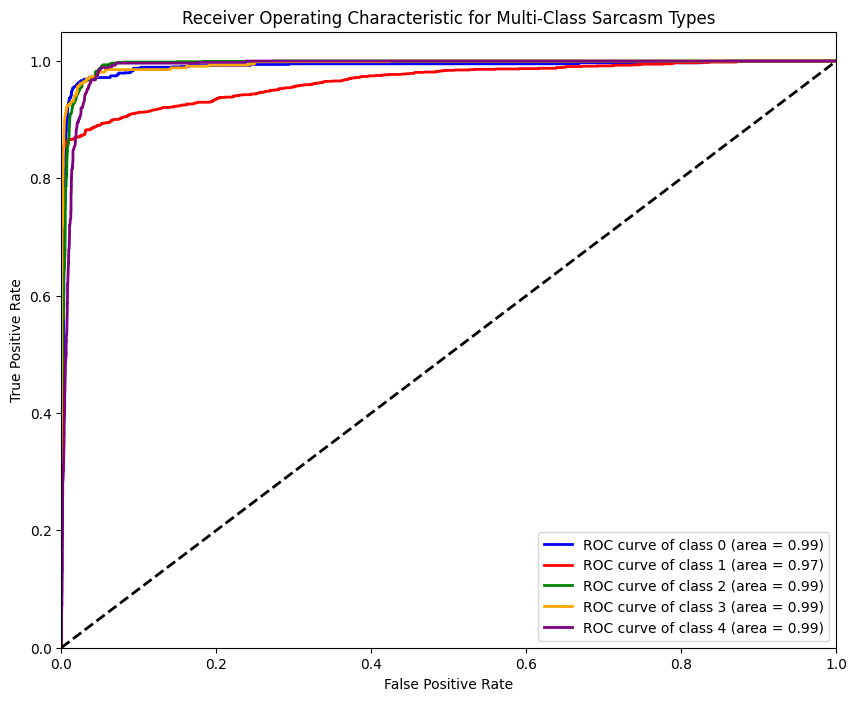

In [ ]:
# Cell 9: ROC Curves for Multi-Class Classification
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Binarize the labels for ROC analysis
y_bin = label_binarize(y_true_classes, classes=[0, 1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Colors for the different classes
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Sarcasm Types')
plt.legend(loc="lower right")
plt.show()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
> Average Accuracy across 10-folds: 90.91% (+/- 1.21%)


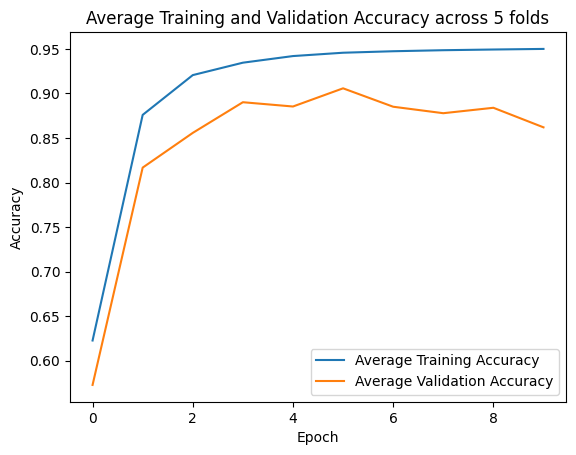

268/268 [==============================] - 11s 39ms/step


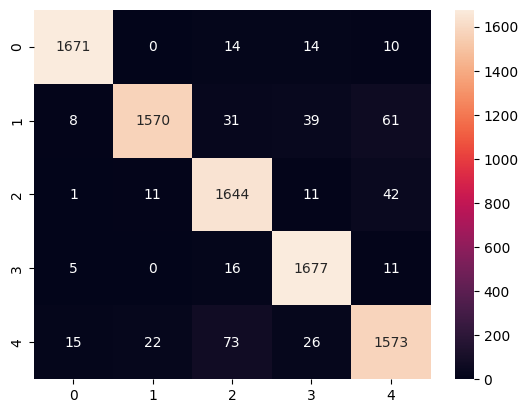

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1709
           1       0.98      0.92      0.95      1709
           2       0.92      0.96      0.94      1709
           3       0.95      0.98      0.96      1709
           4       0.93      0.92      0.92      1709

    accuracy                           0.95      8545
   macro avg       0.95      0.95      0.95      8545
weighted avg       0.95      0.95      0.95      8545



In [1]:
# Cell 1: Setup and Imports
!pip install nltk
!pip install imbalanced-learn
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from nltk.stem import WordNetLemmatizer
from nltk import download
download('wordnet')
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler

# Cell 2: Mount Google Drive
drive.mount('/content/drive')

# Cell 3: Data Loading and Preprocessing
path = '/content/drive/MyDrive/Sarcasm_multiclassification.csv'
df = pd.read_csv(path, encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['comment_Text'] = df['comment_Text'].apply(clean_text)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment_Text'])
X = tokenizer.texts_to_sequences(df['comment_Text'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)
y = pd.get_dummies(df['Sarcasm_Type']).values

# Cell 4: Oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Cell 5: Model Definition with BiGRU
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Cell 6: K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)

    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Cell 7: Results Visualization
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 5 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Cell 8: Performance Metrics
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

print(classification_report(y_true_classes, y_pred_classes))

# End of Notebook
